## Fit the transit in  CHEOPSim simulated dataset  

Data planet orbit and stellar properties for mass and radius estimate from van Grootel et al., [2014ApJ...786....2V](http://simbad.u-strasbg.fr/simbad/sim-ref?bibcode=2014ApJ...786....2V).

- $M_{\star} = 0.77 \pm 0.05 \,M_{\odot}$
- $R_{\star} = 0.741 \pm  (+0.024,-0.023)\, R_{\odot}$
- $P = 9.4903 \pm (+0.0016, -0.0015)$ days
- $f_c= 0.05 \pm (+0.18, -0.20)$
- $f_s= 0.18 \pm (+0.13,-0.23)$
- $e = 0.078\pm (+0.057, -0.053)$ 
- $K = 2.73 \pm (+0.26,-0.27)$ m/s 

In [1]:
%pylab inline
from pycheops import Dataset, StarProperties
from uncertainties import ufloat

# Temporary(?) fix for problem with coordinate look-up for HD stars in astropy 
from astropy.coordinates.name_resolve import sesame_database
sesame_database.set('simbad');


Populating the interactive namespace from numpy and matplotlib


### Create and instance of the dataset

There are 3 ways to load a dataset

1. For authorized DACE users: By specifying the file_key for the dataset. The data will be obtained from the .zip file if it has already downloaded and saved in your pycheops data cache directory. If the .zip file does not exist, the data will be downloaded from DACE and cached. 
```python
>>> dataset = Dataset('CH_PR900048_TG001501_V0000')
```

2. Download an example data set, e.g., 
```python
>>> dataset = Dataset.from_test_data('DP-079', target='HD97658')
```

3. Download the simulated data from CHEOPsim ftp site using the run number, e.g., 
```python
>>> dataset = Dataset.from_simulation(7649, target='HD97658')
```

**N.B.** CHEOPsim output is removed from the FTP server after some time so option 3 may not work for old simulations.


In [2]:
#dataset=Dataset.from_test_data('DP-079', target='HD97658')
#dataset = Dataset.from_simulation(7649, target='HD97658')
dataset = Dataset('CH_PR900048_TG001501_V0000', target='HD97658')
_ = dataset.get_lightcurve(aperture='OPTIMAL')

Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
 Spec. type  : K1
 V magnitude : 7.71 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000-OPTIMAL.fits
Time stored relative to BJD = 2458942
Aperture radius used = 17 arcsec
Mean counts = 97182778.5
Median counts = 97196778.9
RMS counts = 39092.5 [402 ppm]
Median standard error = 10065.7 [104 ppm]


### Estimate stellar density and limb darkening from parameters in SWEET-Cat 

Prior on mean stellar density is helpful to constrain the width of the eclipse.

In [3]:
pHD97658 = StarProperties(dataset.target)
print(pHD97658)
logrhoprior = pHD97658.logrho
# logrhoprior = ufloat(0.0593, 0.1556) # for offline user

Identifier : HD97658
Coordinates: 11:14:33.16 +25:42:37.4
T_eff :  5137 +/- 36 K   [SWEET-Cat]
log g :  4.47 +/- 0.09    [SWEET-Cat]
[M/H] : -0.35 +/- 0.02    [SWEET-Cat]
log rho :  0.06 +/- 0.16  (solar units)
h_1 : 0.710 +/- 0.010     [Stagger]
h_2 : 0.439 +/- 0.051     [Stagger]



### Least-squares fit

Light curve for a planet of radius $R_p$ transiting a star of radius $R_s$ with impact parameter $b$ is calculated using the power-2 limb-darkening law, 
$$I_{\lambda}(\mu) = 1 - c(1 - \mu^{\alpha}),$$
and is described by the following parameters.

- T_0:   time of mid-transit
- P:     orbital period
- D:     depth, $(R_p/R_s)^2 = k^2$
- W:     width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     impact parameter, $a\cos(i)/R_s$
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$
- f_s:   $\sqrt{e}\sin(\omega)$
- h_1:   $I_{\lambda}(0.5) = 1 - c(1-2^{-\alpha})$
- h_2:   $I_{\lambda}(0.5) - I_{\lambda}(0) = c\cdot2^{-\alpha}$


Parameters and their bounds/priors are  specified as follows.

- as a floating point number for fixed parameters, e.g., "P=1.234".
- as a tuple for a free parameter with bounds, e.g., "L = (1e-6,0.1)" or "c = (0.9, 1.0, 1.1)". The median value of the tuple is used as the initial value in the fit.
- as a ufloat floating-point value with a standard error, e.g., "P=ufloat(1.2345,0.0001)", to specify a free parameter with a Gaussian prior.
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"

Trends in the data can be modelled using decorrelation against the following parameters:
 - linear or quadratic decorrelation against position (dfdx, dfdy, df2dx2, d2fdxdy, d2fdx2, d2fdy2);
 - decorrelation against roll angle (dfdsinphi, dfdcosphi, dfdsin2phi, dfdcos2phi);
 - linear or quadratic time trend (dfdt, d2fdt2).
 
In this example we are using decorrelation against the position of the star on the detector.

The output from this method is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.

The limb-darkening is not well constrained by this light curve so we fix the parameter h_2 at its nominal value (".n") and fit the parameter h_1 with a prior.
 

In [4]:
result = dataset.lmfit_transit(P=ufloat(9.4903, 0.0016), T_0=ufloat(0.890,0.001),
                               f_c=ufloat(0.05,0.20), f_s=ufloat(0.13, 0.18),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 224
    # data points      = 582
    # variables        = 9
    chi-square         = 1539.12009
    reduced chi-square = 2.68607346
    Akaike info crit   = 583.992507
    Bayesian info crit = 623.290741
    RMS residual       = 169.1 ppm
[[Variables]]
    T_0:     0.89084742 +/- 0.00163751 (0.18%) (init = 0.89)
    P:       9.49030079 +/- 0.00262228 (0.03%) (init = 9.4903)
    D:       8.1868e-04 +/- 3.1439e-05 (3.84%) (init = 0.001244335)
    W:       0.01449984 +/- 3.5291e-04 (2.43%) (init = 0.02208037)
    b:       0.66636866 +/- 0.00615607 (0.92%) (init = 0.5)
    f_c:     0.05121733 +/- 0.24973764 (487.60%) (init = 0.05)
    f_s:     0.15121643 +/- 0.28059870 (185.56%) (init = 0.13)
    h_1:     0.70176582 +/- 0.01550936 (2.21%) (init = 0.71)
    h_2:     0.439 (fixed)
    c:       1.00009357 +/- 8.5561e-06 (0.00%) (init = 1)
    k:       0.02861251 +/- 5.4940e-04 (1.92%) == 'sqrt(D)'
    aR:      17.201

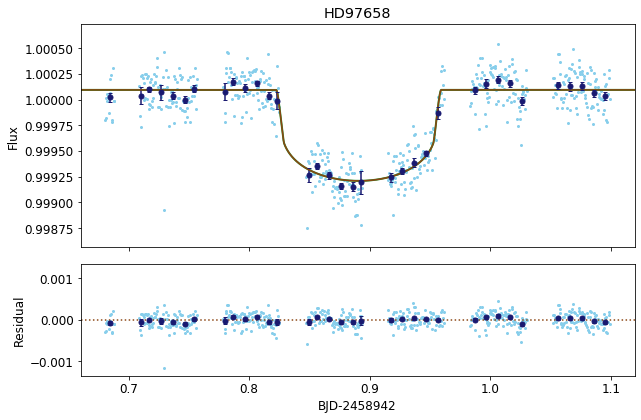

In [5]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)
fig.savefig("HD97658_lmfit.eps")

#### Residuals v. roll angle.
Use `rollangle_plot()` to see if there are any trends correlated with the roll angle of the satellite.

In this case there is no clear trend in the residuals with roll angle so we do not include any decorrelation parameters in the fit, but see `dataset_fit_eclipse_from_simulation` for an example of how to do this.

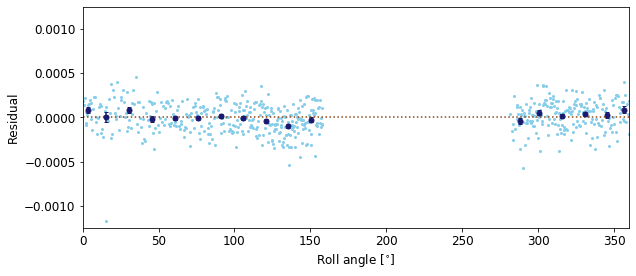

In [6]:
fig = dataset.rollangle_plot(figsize=(9,4),fontsize=12)

### Sampling the posterior
Sampling the posterior probability distribution (ppd) using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

*Using a lower number of burn-in and sampling steps here than would normally be used - just to see how it works*

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

The calculation of the ppd assumes uniform prior probabilities for $\cos i$, $\log k$ and $\log a_R= \log (a/R_{\star})$. The determinant of the Jacobian $J=\frac{\partial(D,W,b)}{\partial(k,aR,\cos i)}$  is $|J| = -2kW$, so $$P(D, W, b) = \frac{P(k, aR, \cos i)}{||J||} = \frac{1}{2k^2  W  a_R}$$ 

In [7]:
sampler = dataset.emcee_sampler(burn=128, steps=64, nwalkers=64, thin=4)
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 128/128 [00:49<00:00,  2.58it/s]

Running sampler ..



100%|██████████| 256/256 [01:58<00:00,  2.15it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 16384
    # data points      = 576
    # variables        = 10
    chi-square         = 1534.95373
    reduced chi-square = 2.71193239
    Akaike info crit   = -8365.25763
    Bayesian info crit = -8321.69655
    RMS residual       = 169.0 ppm
[[Variables]]
    T_0:        0.89070420 +/- 5.8114e-04 (0.07%) (init = 0.89)
    P:          9.48958445 +/- 0.00153888 (0.02%) (init = 9.4903)
    D:          8.0781e-04 +/- 3.9804e-05 (4.93%) (init = 0.001244335)
    W:          0.01439798 +/- 2.4872e-04 (1.73%) (init = 0.02208037)
    b:          0.63459048 +/- 0.07323380 (11.54%) (init = 0.5)
    f_c:        0.05911227 +/- 0.18385474 (311.03%) (init = 0.05)
    f_s:        0.03058392 +/- 0.16144579 (527.88%) (init = 0.13)
    h_1:        0.70458133 +/- 0.01021635 (1.45%) (init = 0.71)
    h_2:        0.439 (fixed)
    c:          1.00009350 +/- 8.8454e-06 (0.00%) (init = 1)
    k:          0.02842194 +/- 5.4940e-04 (1.

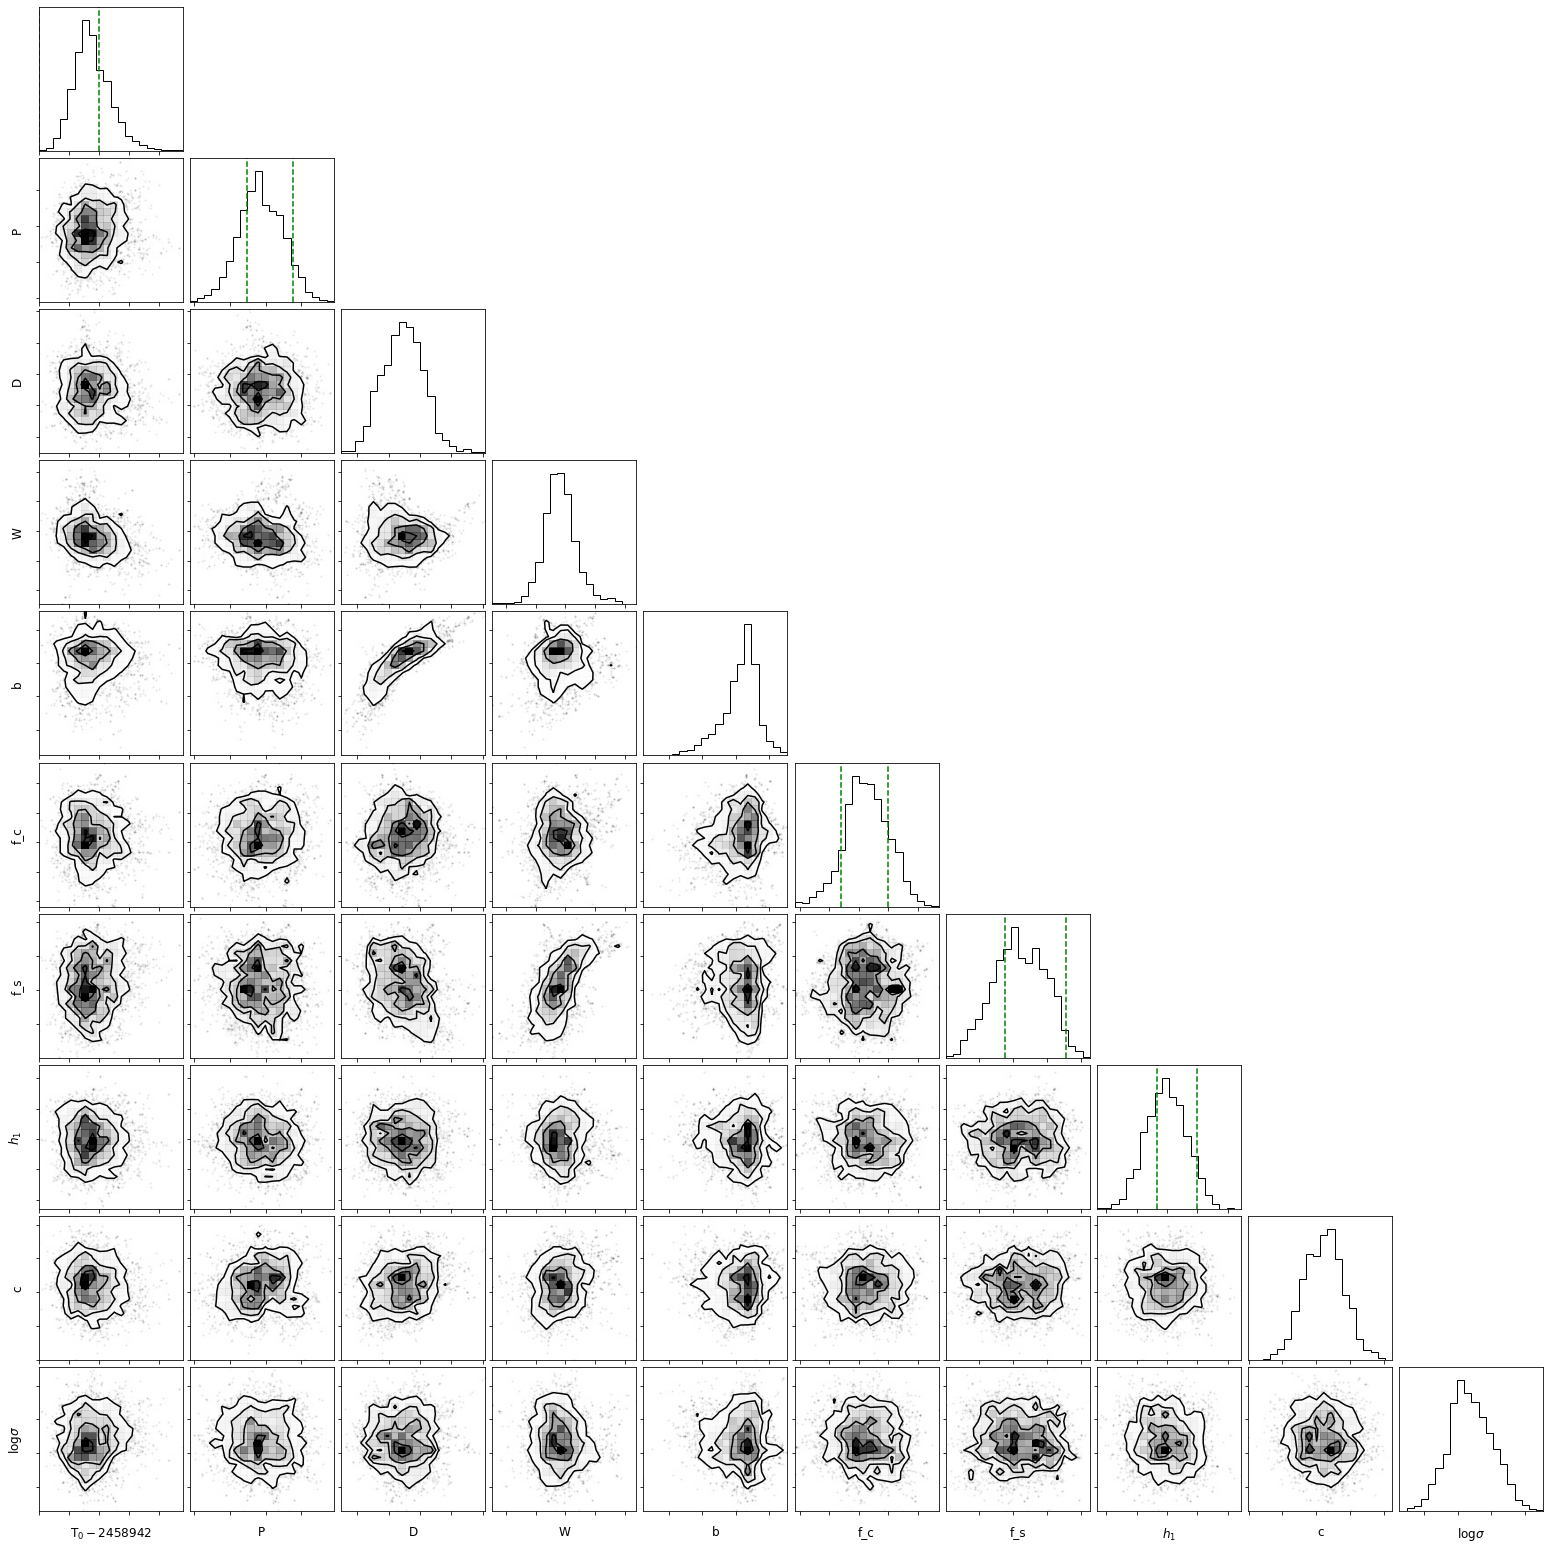

In [8]:
cornerplot = dataset.corner_plot('all')

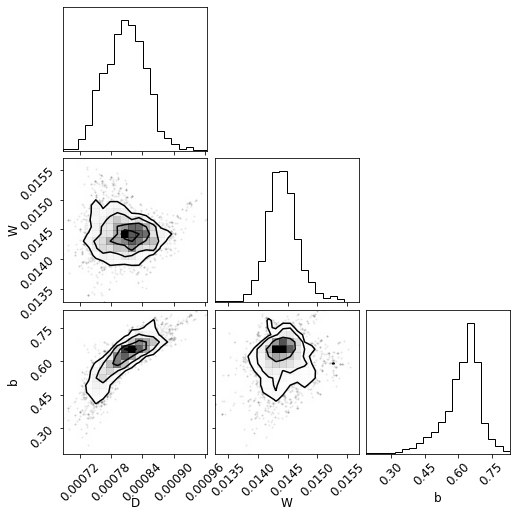

In [9]:
cornerplot = dataset.corner_plot(['D','W','b'],show_ticklabels=True)

#### Light curve fit with trends removed
Light curve fits for nsamples parameter sets from from the sampled posterior distribution are plotted together with the best-fit light curve model.

The plot routine returns a matplotlib [Figure](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure) object so you can, for example, use `fig.savefig("plot.png")` so save the image to a file.

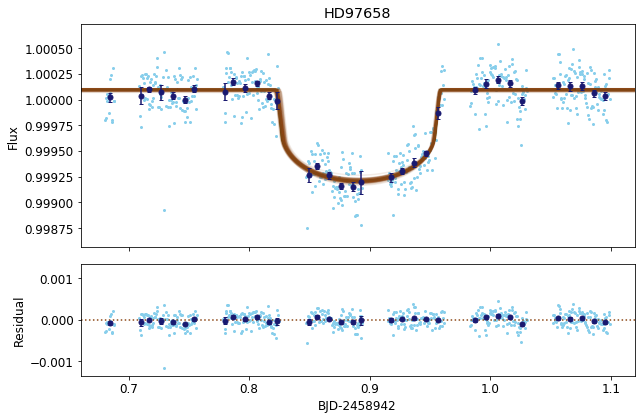

In [10]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12, nsamples=100)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/). By default the parameter quality factor is fixed at $Q=1/\sqrt{2}$ so that the kernel is the one commonly used to model granulation noise
$$ k(\tau) = \omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(-\omega_0\tau/\sqrt{2} - \pi/4\right)$$

Broad uniform priors on noise-model parameters are based on output from a previous run and are set to avoid tail of very low values that mess up the plots.

In [11]:
sampler = dataset.emcee_sampler(log_sigma=(-10.5,-7.5), log_omega0=(3.5,8.5), log_S0=(-30,-20), 
                                add_shoterm=True, burn=256, steps=64, nwalkers=64, thin=8)
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 256/256 [02:19<00:00,  1.84it/s]

Running sampler ..



100%|██████████| 512/512 [04:30<00:00,  1.89it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 576
    # variables        = 12
    chi-square         = 1536.63053
    reduced chi-square = 2.72452222
    Akaike info crit   = -8376.20729
    Bayesian info crit = -8323.93399
    RMS residual       = 169.1 ppm
[[Variables]]
    T_0:         0.89080807 +/- 5.7930e-04 (0.07%) (init = 0.89)
    P:           9.49059194 +/- 0.00158245 (0.02%) (init = 9.4903)
    D:           7.7576e-04 +/- 4.8221e-05 (6.22%) (init = 0.001244335)
    W:           0.01445467 +/- 3.7062e-04 (2.56%) (init = 0.02208037)
    b:           0.57387375 +/- 0.12364806 (21.55%) (init = 0.5)
    f_c:         0.04911920 +/- 0.19581107 (398.64%) (init = 0.05)
    f_s:         0.10605159 +/- 0.15024870 (141.68%) (init = 0.13)
    h_1:         0.70940896 +/- 0.00979986 (1.38%) (init = 0.71)
    h_2:         0.439 (fixed)
    c:           1.00008935 +/- 1.4452e-05 (0.00%) (init = 1)
    k:           0.02785241 +/- 5.4

#### Trail plot
A trail plot is shows the parameter values v. step number for all the walkers in the sampler. This is a very effective way to check that the sampler has converged, i.e., that the sampler is randomly sampling the posterior probability distribution.

In a "well-mixed" chain, the trail plot will look like noise for all the walkers and there will be no trends in the position or width of the trails.

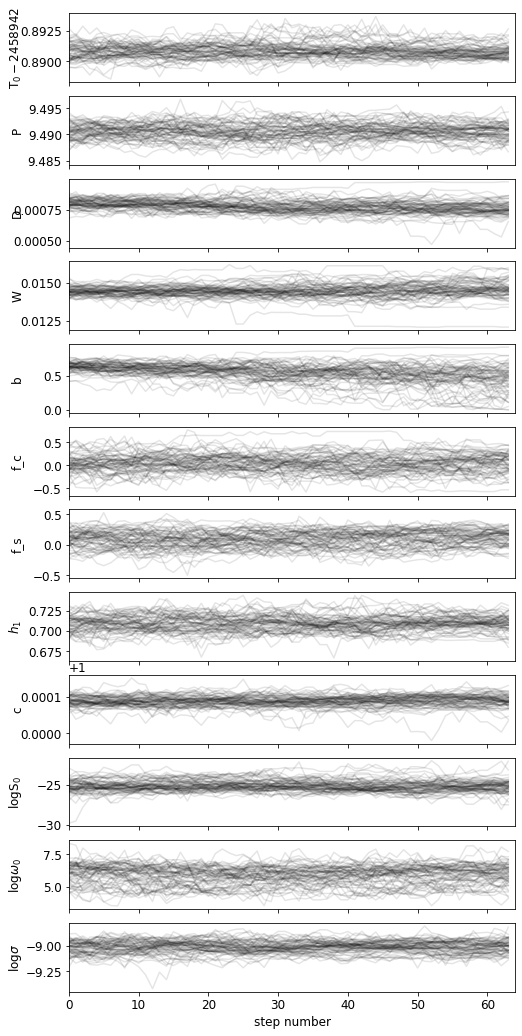

In [12]:
fig = dataset.trail_plot('all')

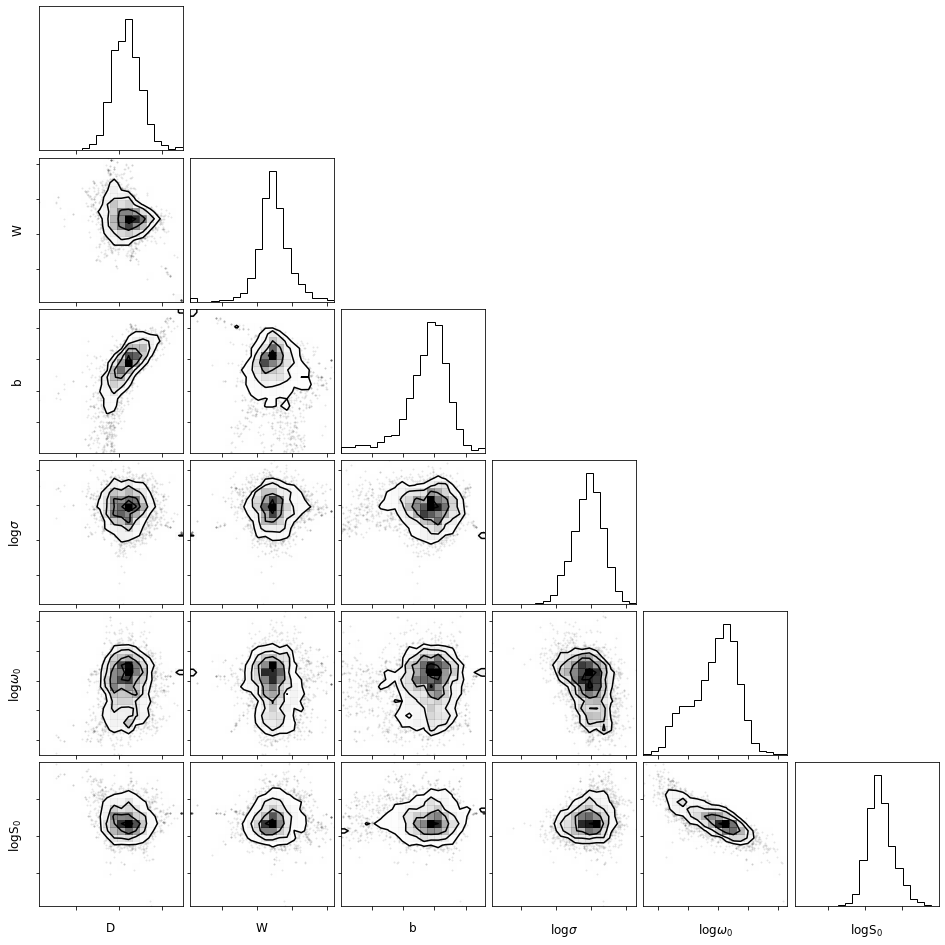

In [13]:
cornerplot = dataset.corner_plot(['D','W','b','log_sigma','log_omega0','log_S0'])

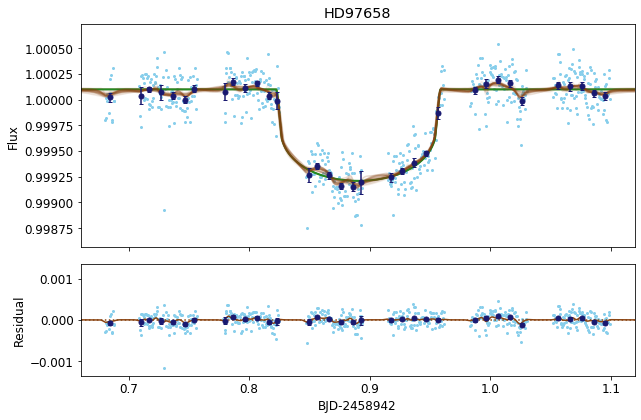

In [14]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12)

#### Power spectrum of the residuals

Lomb-Scargle power-spectrum of the residuals.

If the previous fit included a GP but this is _not_ included in the
calculation of the residuals, i.e., the power spectrum includes the
power "fitted-out" using the GP. The assumption here is that the GP
has been used to model stellar variability that we wish to
characterize using the power spectrum.

The red vertical dotted lines show the CHEOPS  orbital frequency and
its first two harmonics.

The likely range of $\nu_{\rm max}$ is shown using green dashed lines.

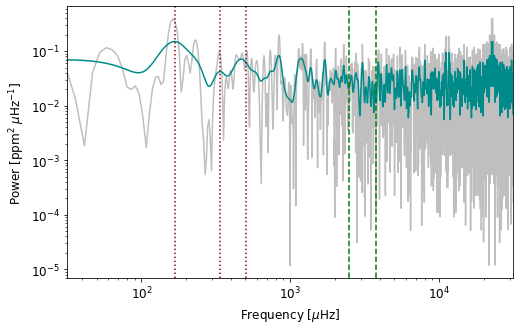

In [15]:
fft = dataset.plot_fft(pHD97658)

#### Mass and radius for the planet.

Compare results using $M_{\star}$ only with stellar density $\rho_{\star}$ from transit fit _cf._ star mass and radius from van Grootel et al.


[[Mass/radius]]
    m_star   =      0.770 +/-      0.050 (    -0.050,    +0.050) M_Earth
    r_star   =      0.923 +/-      0.091 (    -0.084,    +0.098) R_Earth
    r_p      =       2.81 +/-       0.35 (     -0.32,     +0.37) R_Earth
    m_p      =       7.54 +/-       0.81 (     -0.80,     +0.81) M_Earth
    q        =  0.0000295 +/-  0.0000030 (-0.0000029,+0.0000030)
    a        =      17.29 +/-       0.37 (     -0.38,     +0.36) R_Sun
    a        =     0.0804 +/-     0.0017 (   -0.0018,   +0.0017) au
    rho_star =       0.98 +/-       0.29 (     -0.25,     +0.32) rho_Sun
    g_p      =        9.4 +/-        2.5 (      -2.2,      +2.8) m.s-2
    log g_p  =       2.97 +/-       0.11 (     -0.12,     +0.11) [cgs]
    rho_p    =       0.34 +/-       0.13 (     -0.11,     +0.15) rho_Earth
    rho_p    =       1.88 +/-       0.72 (     -0.59,     +0.85) [g.cm-3]


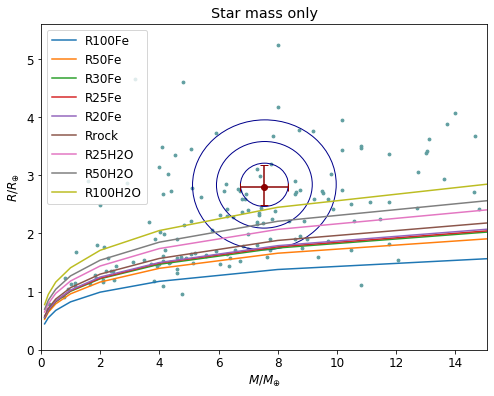

In [16]:
res,fig = dataset.massradius(K=(2.73,0.265),m_star=(0.77,0.05),
                             plot_kws={'baraffe_models':None,
                                       'zeng_models':'all',
                                       'title':'Star mass only'},
                             jovian=False)

[[Mass/radius]]
    m_star   =      0.770 +/-      0.050 (    -0.050,    +0.050) M_Earth
    r_star   =      0.741 +/-      0.023 (    -0.023,    +0.024) R_Earth
    r_p      =       2.25 +/-       0.10 (     -0.10,     +0.10) R_Earth
    m_p      =       7.54 +/-       0.81 (     -0.80,     +0.82) M_Earth
    q        =  0.0000295 +/-  0.0000030 (-0.0000030,+0.0000030)
    a        =      17.29 +/-       0.37 (     -0.38,     +0.37) R_Sun
    a        =     0.0804 +/-     0.0017 (   -0.0018,   +0.0017) au
    rho_star =       0.98 +/-       0.29 (     -0.25,     +0.33) rho_Sun
    g_p      =        9.4 +/-        2.5 (      -2.2,      +2.8) m.s-2
    log g_p  =       2.97 +/-       0.11 (     -0.11,     +0.11) [cgs]
    rho_p    =       0.34 +/-       0.13 (     -0.11,     +0.16) rho_Earth
    rho_p    =       1.87 +/-       0.72 (     -0.59,     +0.86) [g.cm-3]


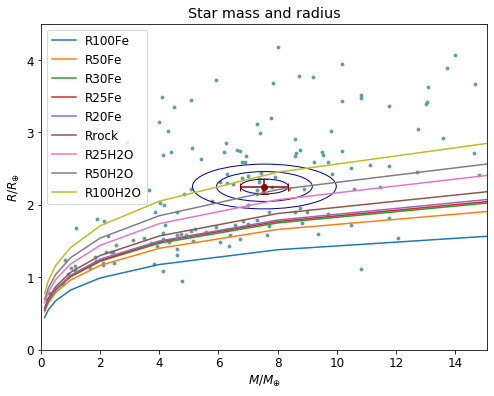

In [17]:
res,fig = dataset.massradius(K=(2.73,0.265),m_star=(0.77,0.05),r_star=(0.741,0.0235),
                             plot_kws={'baraffe_models':None,
                                       'zeng_models':'all',
                                       'title':'Star mass and radius'},
                             jovian=False)

(c) 2020 Pierre Maxted, Keele Univerity, UK